In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from PriceHistory import PriceHistory
from tickers import tickers
from tqdm import tqdm_notebook
%matplotlib inline

Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

In [2]:
ph = PriceHistory(tickers=tickers)
ph.get_data(overwrite=False)

In [3]:
ph.combined_price_history.head()

,Open,High,Low,Close,Adj Close,Volume,ticker,Date,pct_change,log_return,...,momentum,value,rolling_volume,corr,beta,beta_abs,ra_return,security_enc,scaled_volume,volume_rank
Date,,,,,,,,,,,,,,,,,,,,,
1984-12-24,9.43750,9.43750,9.25000,9.40625,1.461496,925200.0,SLB,1984-12-24,-0.016611,-0.016751,...,-0.030918,-0.182653,54258800.0,NaN,NaN,NaN,NaN,0,13.737766,158.0
1984-12-26,9.21875,9.28125,9.15625,9.25000,1.437219,1832800.0,SLB,1984-12-26,0.000000,0.000000,...,-0.029153,-0.195794,54634400.0,NaN,NaN,NaN,NaN,0,14.421356,161.0
1984-12-27,9.25000,9.37500,9.21875,9.25000,1.437219,1650800.0,SLB,1984-12-27,0.013514,0.013423,...,-0.024911,-0.195383,53627200.0,NaN,NaN,NaN,NaN,0,14.316771,160.0
1984-12-28,9.31250,9.40625,9.21875,9.37500,1.456640,2316400.0,SLB,1984-12-28,0.016667,0.016529,...,-0.022946,-0.184170,50875600.0,NaN,NaN,NaN,NaN,0,14.655525,159.0
1984-12-31,9.34375,9.56250,9.25000,9.53125,1.480919,2132800.0,SLB,1984-12-31,-0.003279,-0.003284,...,-0.012248,-0.170253,50467600.0,NaN,NaN,NaN,NaN,0,14.572947,159.0


In [4]:
feature_cols = ['momentum', 'scaled_volume', 'vol', 'security_enc']
target_col = ['week_log_return']
X_train, X_test, y_train, y_test = ph.gen_train_test(feature_cols, target_col)

In [5]:
X_test.shape

(1209316, 4)

# Step 2:
## Build hierarchical regression model

In [6]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

In [8]:
# groupby = 'category'
# sec_category_map = (combined.groupby(['security_enc',groupby]).size()
#                   .reset_index()[groupby].values)

# n_categories = len(np.unique(sec_category_map))
n_securities = len(ph.combined_price_history.ticker.unique())
with pm.Model() as model:
    # Hyperpriors for slope based on vol classification
    a_category_mu = pm.StudentT('a_category_mu', mu=0, sd=3, nu=1)
    a_category_sd = pm.HalfCauchy('a_category_sd', 2)
    
    # Hyperpriors for slope, derived from vol_classification, used for individual security calculatio 
    a_sec = pm.Normal('a_security', mu=a_category_mu, sd=a_category_sd, shape=n_securities)
    a_volume = pm.Normal('a_volume', mu=0, sd=3)
    a_vol    = pm.Normal('a_vol', mu=0, sd=3)
    
    # Calculate the intercept for each security independently, nothing fancy here
    b_sec = pm.Uniform('b_security', -1, 1, shape=n_securities)
    
    p = invlogit((X_train['momentum'].values * a_sec[X_train['security_enc'].values] +
                  X_train['vol'].values * a_vol +
                  X_train['scaled_volume'].values * a_volume +
                  b_sec[X_train['security_enc'].values]))
    
    likelihood = pm.Bernoulli('likelihood', p=p, observed=np.where(y_train['week_log_return'].values > 0, 1, 0))
#     mom_trace = pm.sample(500, init='advi', n_init=50000, step=pm.NUTS())

In [9]:
with model:
    mom_trace = pm.sample(draws=50, tune=200, init='advi', n_init=50000, step=pm.NUTS())

100%|██████████| 250/250 [6:58:32<00:00, 266.36s/it]/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:429: UserWarning: Chain 0 contains only 50 samples.
  % (self._chain_id, n))
/Users/benjaminglickenhaus/anaconda/envs/new_theano/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



In [27]:
# with model:
#     approx = pm.fit(50000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

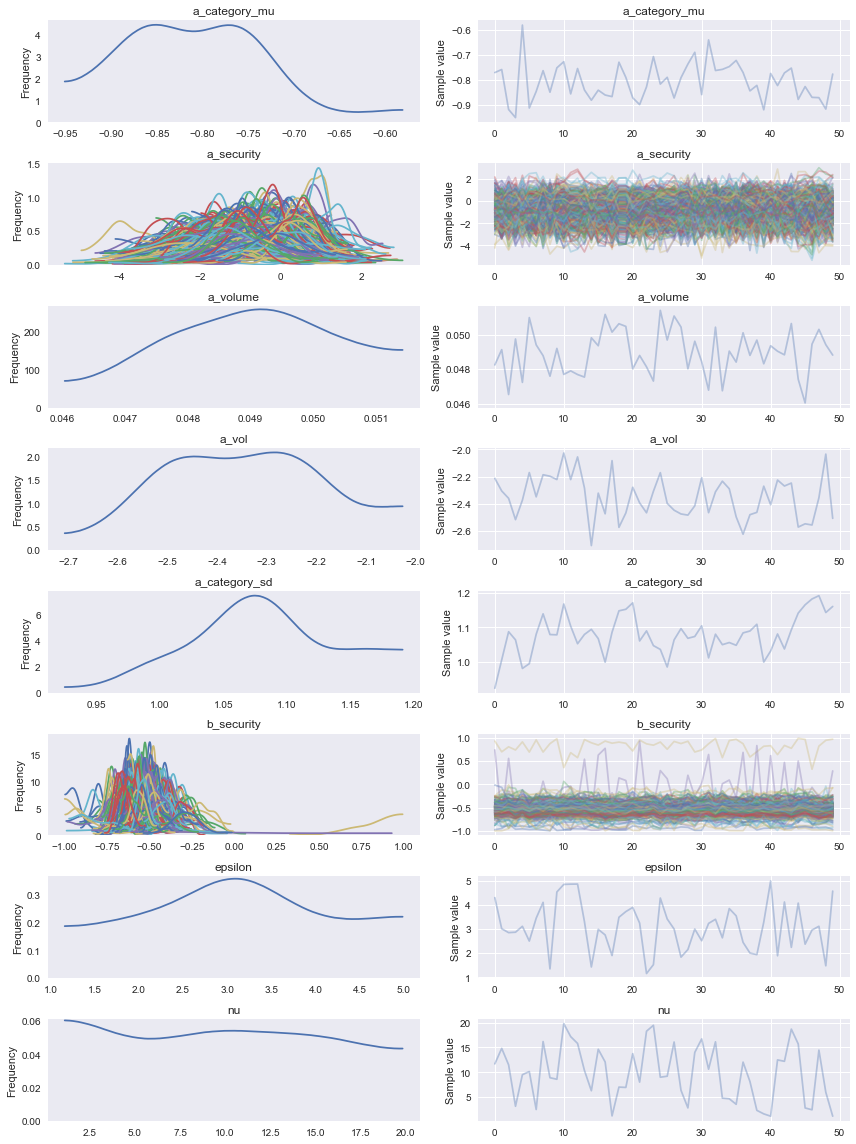

In [11]:
pm.traceplot(mom_trace);

In [12]:
def calc_prediction_helper(row, *args):
    if args[0] == 'momentum':
        a = invlogit((
                row.momentum * mom_trace['a_security'][:, row.security_enc] +
                row.scaled_volume * mom_trace['a_volume'] +
                row.vol * mom_trace['a_vol'] *
                mom_trace['b_security'][:, row.security_enc]))
    elif args[0] == 'value':
        a = ((row.value * val_trace['a_security'][:, row.security_enc]) + 
             (row.beta_abs * val_trace['a_beta']) +
             val_trace['b_security'][:, row.security_enc])
    return np.mean(a)

In [15]:
X_test = X_test.reset_index()
y_test = y_test.reset_index()

In [34]:
sec_category_map = (ph.combined_price_history.groupby(['security_enc','ticker']).size()
                    .reset_index()['ticker'].values)

In [37]:
sec_category_map

array(['SLB', 'MNST', 'AVB', 'PPLT', 'GIS', 'FDX', 'STX', 'GM', 'MMM',
       'ETR', 'BXP', 'AGN', 'ETFC', 'SPGI', 'AES', 'DAL', 'MAC', 'RE',
       'JO', 'GE', 'NBL', 'CME', 'HES', 'CAH', 'PNR', 'MTB', 'MOS', 'IDXX',
       'ANSS', 'AXP', 'URI', 'ITW', 'AMP', 'PH', 'DG', 'CCI', 'AMT',
       'CHRW', 'ABC', 'LMT', 'DVN', 'DUK', 'COTY', 'AGG', 'JPM', 'AMGN',
       'GILD', 'ARE', 'MYL', 'APD', 'IFF', 'MSI', 'VRSN', 'ECL', 'CSX',
       'LQD', 'KEY', 'VLO', 'APC', 'EWJ', 'SO', 'FCX', 'VRSK', 'MS', 'COH',
       'AIG', 'KSS', 'REGN', 'LKQ', 'AOS', 'EA', 'HD', 'SPLS', 'FRT',
       'SWKS', 'DRE', 'HRB', 'HSY', 'XRX', 'XRAY', 'UNM', 'AEE', 'STT',
       'BZF', 'IVZ', 'VRTX', 'DIS', 'NEM', 'SPY', 'DLR', 'MTD', 'LYB',
       'CB', 'WAT', 'MA', 'FBHS', 'HOLX', 'SBUX', 'NTRS', 'ROST', 'NWL',
       'DFS', 'RTN', 'CAT', 'TXN', 'UDR', 'LLY', 'EMN', 'PHM', 'CHD', 'DE',
       'LNT', 'CAG', 'GLD', 'ED', 'GPC', 'VTR', 'GT', 'AWK', 'BLK', 'SEE',
       'FOXA', 'RHT', 'KMB', 'PEG', 'INCY', 'NWS', 'PFG

In [42]:
dists = {}
for v in mom_trace.varnames:
    dists[v] = {}
    _a = mom_trace.get_values(v)
    if len(_a.shape) > 1:
        for i, d in enumerate(_a.transpose()):
            dists[v][sec_category_map[i]] = d
    else:
        dists[v]['sec'] = _a
            

In [43]:
dists

{'a_category_mu': {'sec': array([-0.77067455, -0.75849904, -0.91821664, -0.95073921, -0.58081874,
         -0.91225004, -0.84611651, -0.76303098, -0.84912034, -0.75171112,
         -0.72723364, -0.85589229, -0.75453741, -0.84045363, -0.88122283,
         -0.84096909, -0.86038524, -0.86676157, -0.72920361, -0.78992118,
         -0.87140255, -0.89882793, -0.82767678, -0.70675058, -0.81664847,
         -0.78971716, -0.87232773, -0.79124578, -0.73669974, -0.68965728,
         -0.85878101, -0.64016231, -0.7624217 , -0.75795134, -0.74671255,
         -0.72210399, -0.77023314, -0.84386588, -0.8219407 , -0.9194504 ,
         -0.77422141, -0.82254586, -0.77202374, -0.75273851, -0.87809055,
         -0.82672412, -0.86968332, -0.87092476, -0.91655351, -0.77670423])},
 'a_category_sd': {'sec': array([ 0.92500769,  1.00664136,  1.08748405,  1.06412785,  0.98185279,
          0.99557594,  1.08023776,  1.1388978 ,  1.07938531,  1.07857875,
          1.16719455,  1.1036699 ,  1.05300049,  1.07966808, 

In [16]:
tqdm_notebook().pandas(desc='Prob')
y_test['prediction'] = X_test.progress_apply(calc_prediction_helper, axis=1, args=('momentum', ))

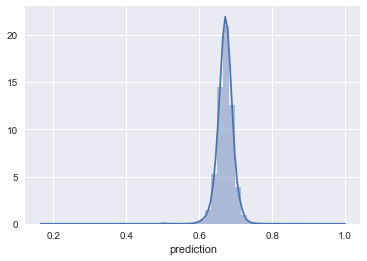

In [18]:
sns.distplot(y_test.prediction)

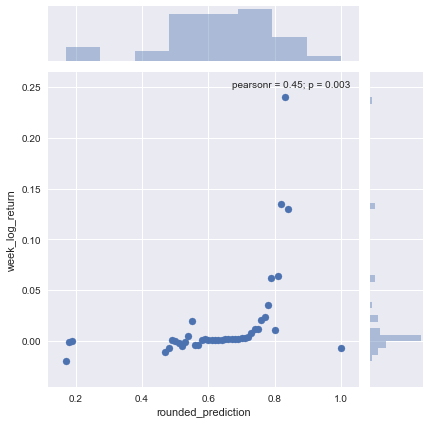

In [19]:
y_test['rounded_prediction'] = y_test['prediction'].round(2)
sns.jointplot(y_test.groupby('rounded_prediction').mean()['week_log_return'].index,
              y_test.groupby('rounded_prediction').mean()['week_log_return'])

In [25]:
low, high = y_test.prediction.quantile([.5, .5])
print('Avg. return on long positions: {}'.format(y_test.loc[y_test.prediction >= high, 'week_log_return'].mean()))
print('Avg. return on short positions: {}\n'.format(y_test.loc[y_test.prediction <= low, 'week_log_return'].mean()))

Avg. return on long positions: 0.002289080845550963
Avg. return on short positions: 0.0015119132261319443



In [49]:
ticker_to_a = dict()
ticker_to_b = dict()
for t, i in security_encodings.items():
    ticker_to_a[t] = mom_trace['a_security'][:, i]
    ticker_to_b[t] = mom_trace['b_security'][:, i]

In [50]:
s = 'dict('
for t, a in ticker_to_a.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(SGG=[-0.0990441400655, 1.87571065204, 1.53768678895, 1.50982457117, 0.935739651019, -2.15923727881, -2.15923727881, -2.06455500933, -0.119169593281, 0.155929091439, 0.155929091439, -0.158994641369, 0.127384346149, -0.0964001429323, 0.307616011975, 0.307616011975, -0.0601108368271, 0.447155112614, -0.43388577576, -0.507728278671, -0.507728278671, -0.297692537232, 0.0746942148253, -0.013876536069, 0.172546452206, -0.149736913182, 0.442617410831, 0.0213024945722, 0.136738714423, 0.186254457081, 0.633379766105, -0.135988182844, 0.185062796745, 0.0188479891821, 0.537489127302, 0.0601211433989, 0.0549313346116, 0.0772273388329, 0.0772273388329, -0.00801677466656, 1.00671363138, 0.599033162574, 0.0235514104809, 0.196290801747, -0.341596983468, 0.437420970063, 0.437420970063, 0.242204930426, -0.0907063465331, -0.198059553804, 0.187175970038, 0.477731125701, -0.472587279205, -0.472587279205, 0.0646846894219, 0.278632310165, -0.345376397862, -0.345376397862, -0.328353737256, 0.59939464126, 

In [51]:
s = 'dict('
for t, a in ticker_to_b.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(SGG=[-0.00388761954875, -0.164191636338, -0.148432875476, -0.106859530736, -0.0697532921027, 0.14084995424, 0.14084995424, 0.136275905175, 0.00373361508819, -0.00436603928566, -0.00436603928566, 0.0120736010596, 0.000730129707627, -0.0176309342996, -0.00491568425513, -0.00491568425513, -0.0118712750897, -0.00513788820369, -0.00722325651298, -0.0264846838586, -0.0264846838586, -0.010851626611, -0.00782782889033, -0.0029716158216, -0.0154064705724, -0.00238270154296, -0.0119352456446, 0.0151768049826, -0.0399684535376, 0.0188339147827, 0.0294740949543, -0.0498307174071, 0.0245857975951, -0.0335666052543, 0.0321072004635, -0.0619428895774, -0.0648577863623, 0.0544309835175, 0.0544309835175, -0.0298824214379, 0.0155464457222, -0.00156310344447, -0.0186988481519, -0.0280348617483, -0.0156231993837, -0.0291012852779, -0.0291012852779, -0.0309571151015, -0.0516613993255, -0.0756379802493, -0.0747538959132, -0.072489061246, -0.000191851482879, -0.000191851482879, -0.0185057209708, -0.0223

In [53]:
s = '['
for a in mom_trace['a_beta']:
    s += str(a) + ', '
s = s[:-2]
s += ']'
print(s)

[-0.00205191280071, 0.00140859789605, 0.00213703421077, -0.00245504498072, -0.00670730274752, -0.0245692102728, -0.0245692102728, -0.0225024701847, -0.00466659956605, 5.80876756411e-05, 5.80876756411e-05, 0.00883768306833, 0.0178366259992, 0.0214916483032, 0.02476503835, 0.02476503835, 0.023529257624, 0.0170232653708, 0.0135510868741, 0.012979707008, 0.012979707008, 0.0163360576402, 0.0182864717623, 0.0243275395462, 0.03262720286, 0.0447897543372, 0.0473240438301, 0.0376302432799, 0.041340098475, 0.0322569839529, 0.0298490899511, 0.0331137125813, 0.00648378050441, 0.0259480581171, 0.0244060146872, 0.00713276155861, 0.00962087136908, 0.0326215766812, 0.0326215766812, 0.031252298339, 0.0312656260216, 0.050048746508, 0.0580039227587, 0.0619881053731, 0.0753825966364, 0.0842285927456, 0.0842285927456, 0.0850095327499, 0.0875669003867, 0.0864379516772, 0.0860663142937, 0.0848981713184, 0.0771498988098, 0.0771498988098, 0.0697806412171, 0.0763970285244, 0.0616992256633, 0.0616992256633, 0.06

# Value Regression

In [54]:
prices, combined = build_prices_dfs(tickers, 3)

slow_window = 252 * 3
for ticker in combined['ticker'].unique():
    combined.loc[combined['ticker'] == ticker, 'slow'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
combined['value'] = pd.to_numeric((combined['Close'] - combined['slow']) / combined['slow'])
combined = combined.dropna()

category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)

n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

train, test = train_test_split(combined, test_size=.3)

with pm.Model() as model:
    # Hyperpriors for slope based on vol classification
    a_category_mu = pm.StudentT('a_category_mu', mu=0, sd=3, nu=1)
    a_category_sd = pm.HalfCauchy('a_category_sd', 2)
    
    # Hyperpriors for slope, derived from vol_classification, used for individual security calculation
    a_category = pm.Normal('a_category', mu=a_category_mu, sd=a_category_sd, shape=n_categories)
    a_sec_sd = pm.Uniform('a_security_sd', 1, 5)
        
    a_sec = pm.Normal('a_security', mu=a_category[sec_category_map], sd=a_sec_sd, shape=n_securities)
    a_beta = pm.Normal('a_beta', mu=0, sd=5)

    # Calculate the intercept for each security independently, nothing fancy here
    b_sec = pm.Uniform('b_security', -1, 1, shape=n_securities)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = ((train['value'].values * a_sec[train['security_enc'].values]) +
             (train['beta_abs'].values * a_beta) + 
             b_sec[train['security_enc'].values])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=train['ra_month_return'].values)
    val_trace = pm.sample(250, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:33: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
100%|██████████| 250/250 [19:20<00:00,  4.89s/it]


In [55]:
test['prediction'] = test.apply(calc_prediction_helper, axis=1, args=('value', ))

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


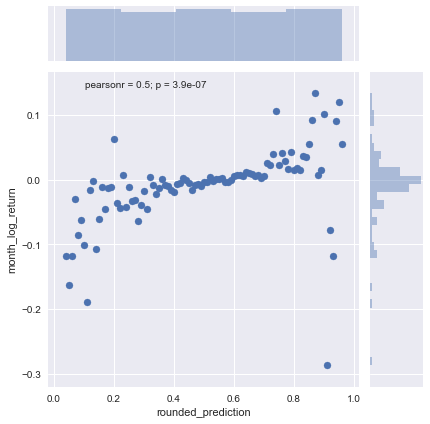

In [56]:
test['rounded_prediction'] = test['prediction'].round(2)
sns.jointplot(test.groupby('rounded_prediction').mean()['month_log_return'].index, test.groupby('rounded_prediction').mean()['month_log_return'])

In [57]:
ticker_to_a = dict()
ticker_to_b = dict()
for t, i in security_encodings.items():
    ticker_to_a[t] = val_trace['a_security'][:, i]
    ticker_to_b[t] = val_trace['b_security'][:, i]

In [58]:
s = 'dict('
for t, a in ticker_to_a.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(SGG=[-0.000642378661612, -0.000642378661612, 0.102905388307, 0.0955848899639, 0.0349576900345, 0.0164560164134, 0.0297306210727, 0.0741592095645, 0.135675254466, 0.149640324104, 0.143486758414, 0.274369915283, 0.286487860189, 0.25640369715, 0.226896073065, 0.226896073065, 0.274739393275, 0.25920648334, 0.252129847304, 0.181005442288, -0.409217325565, -0.409217325565, -0.380337763554, -0.0607406976594, -0.0760820862935, -0.0760820862935, -0.0769893861575, -0.0349899133008, -0.137461229903, 0.0619720332928, 0.0441998505853, -0.117557361116, 0.0258394057301, -0.120556199607, -0.185549872786, -0.138948470921, 0.0247355897667, -0.112070714669, -0.100612153859, 0.0386187020173, -0.111641138566, -0.111641138566, 0.0669546887243, -0.132082782864, -0.244580681247, -0.244580681247, -0.260595291439, -0.221305631114, 0.0351261969965, 0.0337822472048, -0.189726836045, 0.0518675119813, -0.0388885506688, 0.0805042333027, -0.123380031016, 0.0139682137728, -0.093542034829, 0.0303647658726, -0.1119

In [59]:
s = 'dict('
for t, a in ticker_to_b.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(SGG=[0.00474437678656, 0.00474437678656, -0.00554056483763, -0.00633848154152, -0.0144855264028, -0.0106323681745, -0.0118869461512, -0.00708243799555, 0.00628948721039, 0.00376410936005, 0.00450570968579, 0.0105175402657, 0.00118986020898, -0.0109167154207, -0.0318666918825, -0.0318666918825, -0.0513752171582, -0.0771910154998, -0.0920237484797, -0.105930863774, -0.00545378766314, -0.00545378766314, -0.0238375955909, -0.0194497234259, 0.00502438545953, 0.00502438545953, -0.0675775616743, 0.00197414565529, -0.00983615698526, 0.0320833110941, -0.00242001007905, 0.000755509210482, 0.0116453145915, -0.00917369160873, -0.0033198512213, -0.0284589472039, 0.0109561615356, -0.0264188092153, -0.0116282603582, -0.0430845684012, 0.0320569553114, 0.0320569553114, -0.0242798067378, -0.0747854585809, -0.0589470819259, -0.0589470819259, -0.0705469591563, -0.0570789028839, -0.0261731195025, -0.0270103198138, -0.0387884398697, -0.0159446116313, 0.00841430769956, -0.0189980589272, -0.0732954586886

In [60]:
s = '['
for a in mom_trace['a_beta']:
    s += str(a) + ', '
s = s[:-2]
s += ']'
print(s)

[-0.00205191280071, 0.00140859789605, 0.00213703421077, -0.00245504498072, -0.00670730274752, -0.0245692102728, -0.0245692102728, -0.0225024701847, -0.00466659956605, 5.80876756411e-05, 5.80876756411e-05, 0.00883768306833, 0.0178366259992, 0.0214916483032, 0.02476503835, 0.02476503835, 0.023529257624, 0.0170232653708, 0.0135510868741, 0.012979707008, 0.012979707008, 0.0163360576402, 0.0182864717623, 0.0243275395462, 0.03262720286, 0.0447897543372, 0.0473240438301, 0.0376302432799, 0.041340098475, 0.0322569839529, 0.0298490899511, 0.0331137125813, 0.00648378050441, 0.0259480581171, 0.0244060146872, 0.00713276155861, 0.00962087136908, 0.0326215766812, 0.0326215766812, 0.031252298339, 0.0312656260216, 0.050048746508, 0.0580039227587, 0.0619881053731, 0.0753825966364, 0.0842285927456, 0.0842285927456, 0.0850095327499, 0.0875669003867, 0.0864379516772, 0.0860663142937, 0.0848981713184, 0.0771498988098, 0.0771498988098, 0.0697806412171, 0.0763970285244, 0.0616992256633, 0.0616992256633, 0.06

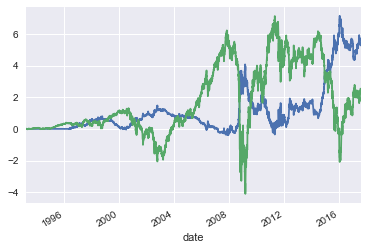

In [454]:
combined.groupby('date').sum()['bt_return'].cumsum().plot()
combined.groupby('date').sum()['log_return'].cumsum().plot()

In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

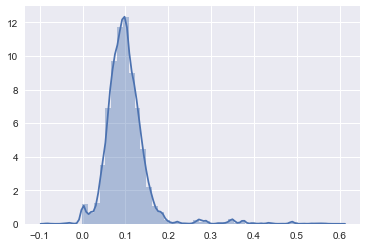

In [319]:
sns.distplot(trace['a_security'][:, 10])

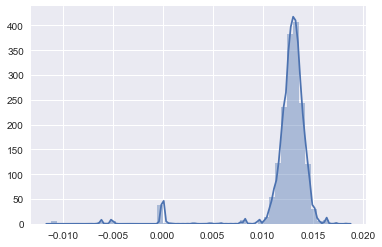

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6


In [227]:
pd.DataFrame([1,2,3,4]).shift(1).rolling(3).mean()

,0
0,NaN
1,NaN
2,NaN
3,2.0
